In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import trange

## Comparison between Ordinary and Lazy PageRank

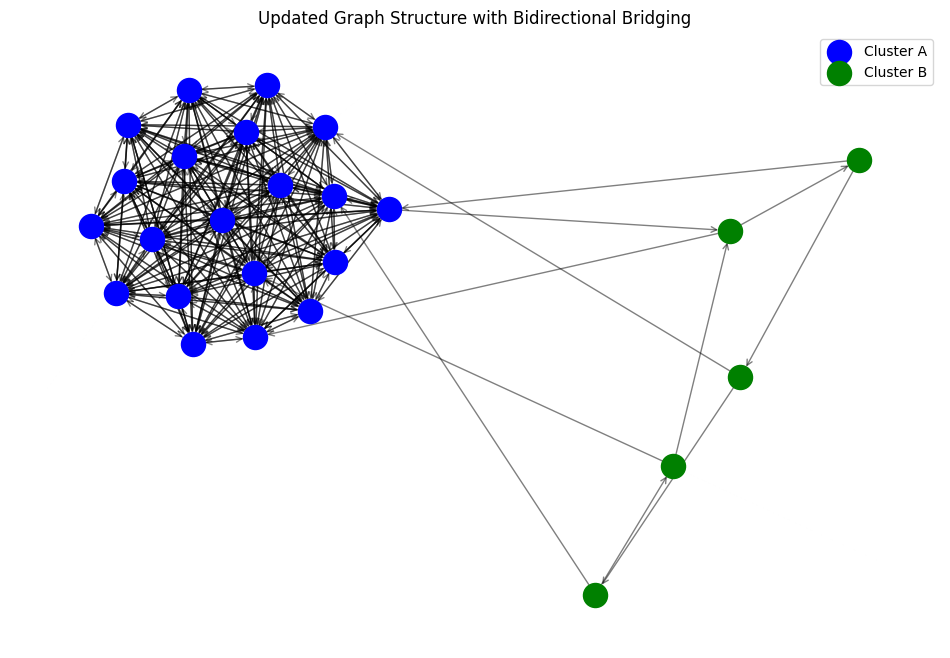

In [2]:
# Create an empty directed graph
G = nx.DiGraph()

# Cluster A: Dense SCC with 20 nodes
cluster_a_nodes = range(1, 21)
G.add_nodes_from(cluster_a_nodes)

# Add edges to make Cluster A strongly connected
for node in cluster_a_nodes:
    for target in cluster_a_nodes:
        if node != target:
            G.add_edge(node, target)

# Cluster B: Sparse component with 5 nodes
cluster_b_nodes = range(21, 26)
G.add_nodes_from(cluster_b_nodes)

# Add sparse edges within Cluster B (forming a ring)
for i in range(len(cluster_b_nodes)):
    G.add_edge(cluster_b_nodes[i], cluster_b_nodes[(i + 1) % len(cluster_b_nodes)])

# Bridging edges from Cluster B to Cluster A
for node in cluster_b_nodes:
    target = random.choice(list(cluster_a_nodes))
    G.add_edge(node, target)

# **New:** Bridging edges from Cluster A to Cluster B
for node in cluster_a_nodes:
    if random.random() < 0.1:  # 10% chance to add an edge to Cluster B
        target = random.choice(list(cluster_b_nodes))
        G.add_edge(node, target)

# Visualize the updated graph structure
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', label='Cluster A')
nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', label='Cluster B')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.5)
plt.title('Updated Graph Structure with Bidirectional Bridging')
plt.legend()
plt.axis('off')
plt.show()


In [ ]:
# # Create a graph with characteristics where Lazy PageRank converges faster
# # 1. Include dangling nodes
# # 2. Disconnected components
# # 3. Strongly connected clusters

# # Initialize the graph
# G = nx.DiGraph()

# # Add a strongly connected cluster (component 1)
# G.add_edges_from([
#     (1, 2), (2, 3), (3, 4), (4, 1), (2, 4), (3, 1)
# ])

# # Add another strongly connected cluster (component 2)
# G.add_edges_from([
#     (5, 6), (6, 7), (7, 8), (8, 5), (6, 8), (7, 5)
# ])

# # Add dangling nodes connected to cluster 1
# G.add_edges_from([
#     (9, 1), (10, 2)
# ])

# # Add dangling nodes connected to cluster 2
# G.add_edges_from([
#     (11, 5), (12, 6)
# ])

# # Add disconnected nodes (dangling nodes with no outgoing edges)
# G.add_nodes_from([13, 14])

# # Visualize the graph
# pos = nx.spring_layout(G, seed=42)  # Position for consistent layout
# plt.figure(figsize=(10, 8))
# nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=15)
# plt.title("Graph with Properties Favorable for Lazy PageRank")
# plt.show()


In [3]:
def power_iteration(P, alpha=0.85, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    for i in range(max_iter):
        r_new = alpha * P.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals

def power_iteration_lazy(P, alpha=0.85, lazy_prob=0.5, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    P_lazy = lazy_prob * np.eye(n) + (1 - lazy_prob) * P
    for i in range(max_iter):
        r_new = alpha * P_lazy.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals


In [4]:
# Get the adjacency matrix as a dense numpy array
A = nx.adjacency_matrix(G).astype(float).toarray()
n = A.shape[0]

# Compute row sums
row_sums = A.sum(axis=1)
dangling_nodes = (row_sums == 0)

# Avoid division by zero; replace zeros in row_sums
row_sums_fixed = row_sums.copy()
row_sums_fixed[dangling_nodes] = 1.0

# Normalize to create transition matrix P
P = A / row_sums_fixed[:, np.newaxis]

# For dangling nodes, set rows to uniform probability
P[dangling_nodes, :] = 1.0 / n

# Ordinary PageRank
pr_ordinary, residuals_ordinary = power_iteration(P)

# Lazy PageRank
pr_lazy, residuals_lazy = power_iteration_lazy(P, lazy_prob=0.5)


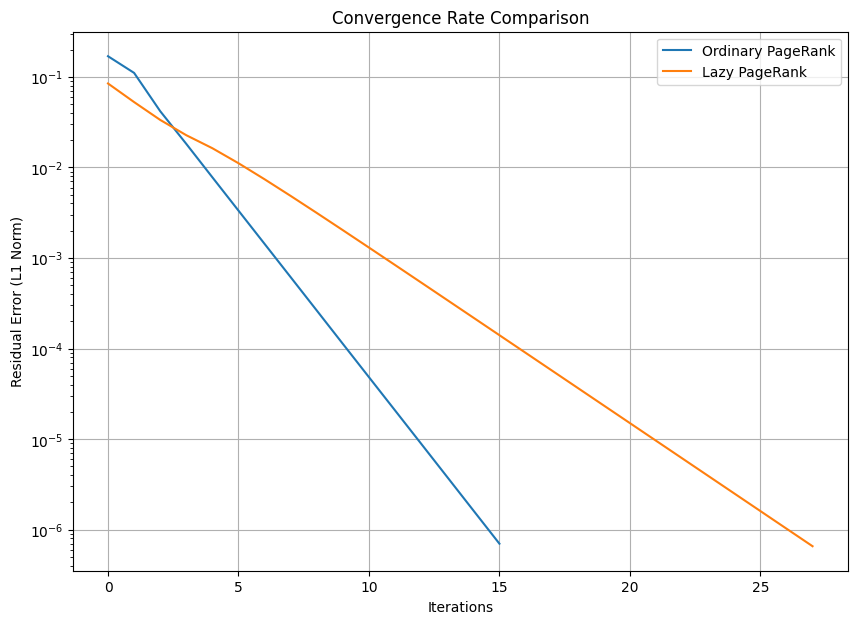

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(residuals_ordinary, label='Ordinary PageRank')
plt.plot(residuals_lazy, label='Lazy PageRank')
plt.xlabel('Iterations')
plt.ylabel('Residual Error (L1 Norm)')
plt.title('Convergence Rate Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


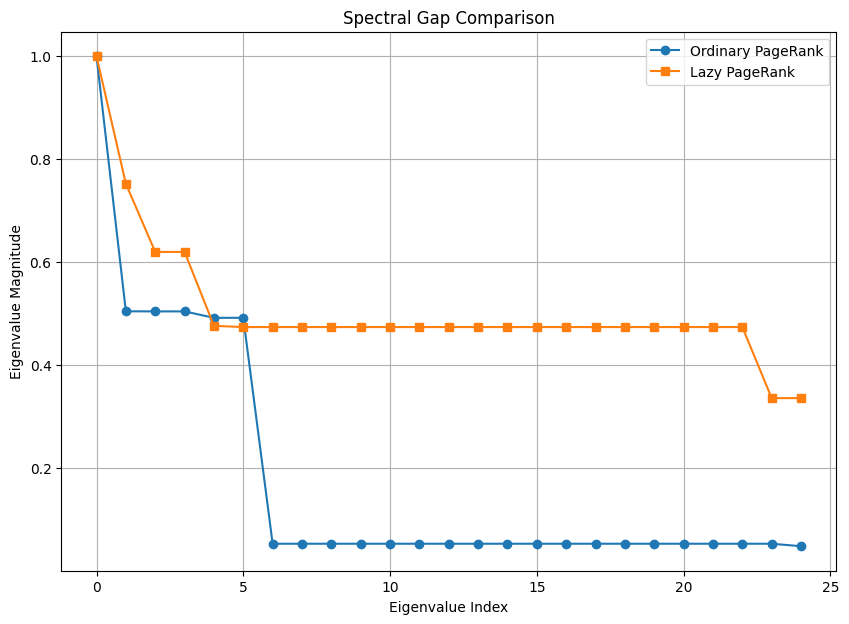

In [6]:
# Ordinary Transition Matrix
eigvals_ordinary = np.linalg.eigvals(P.T)

# Lazy Transition Matrix
P_lazy = 0.5 * np.eye(n) + 0.5 * P
eigvals_lazy = np.linalg.eigvals(P_lazy.T)

# Sort eigenvalues in descending order
eigvals_ordinary = np.sort(np.abs(eigvals_ordinary))[::-1]
eigvals_lazy = np.sort(np.abs(eigvals_lazy))[::-1]

# Plot the eigenvalues
plt.figure(figsize=(10, 7))
plt.plot(eigvals_ordinary.real, marker='o', label='Ordinary PageRank')
plt.plot(eigvals_lazy.real, marker='s', label='Lazy PageRank')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Spectral Gap Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def simulate_hitting_time(G, start_node, target_node, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Ordinary Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)

def simulate_hitting_time_lazy(G, start_node, target_node, lazy_prob=0.5, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Lazy Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            if random.random() < lazy_prob:
                continue  # Stay at the same node
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)


In [8]:
# Function to check mutual reachability
def are_mutually_reachable(G, node1, node2):
    return nx.has_path(G, node1, node2) and nx.has_path(G, node2, node1)

# Select node pairs that are mutually reachable
def select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes):
    while True:
        node_a = random.choice(list(cluster_a_nodes))
        node_b = random.choice(list(cluster_b_nodes))
        if are_mutually_reachable(G, node_a, node_b):
            return node_a, node_b

# Select a valid node pair
node_a, node_b = select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes)
print(f"Selected Node A: {node_a} (Cluster A), Node B: {node_b} (Cluster B)")


Selected Node A: 19 (Cluster A), Node B: 23 (Cluster B)


Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

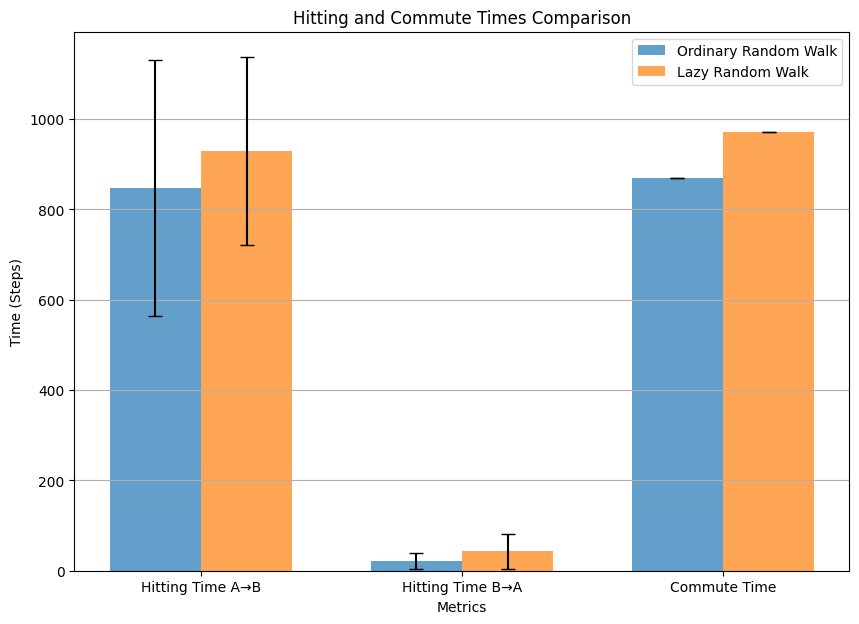

In [9]:
# Compute Hitting and Commute Times

# Ordinary Random Walk
hitting_time_ab_ord, std_ab_ord = simulate_hitting_time(G, node_a, node_b)
hitting_time_ba_ord, std_ba_ord = simulate_hitting_time(G, node_b, node_a)
commute_time_ord = hitting_time_ab_ord + hitting_time_ba_ord

# Lazy Random Walk
hitting_time_ab_lazy, std_ab_lazy = simulate_hitting_time_lazy(G, node_a, node_b, lazy_prob=0.5)
hitting_time_ba_lazy, std_ba_lazy = simulate_hitting_time_lazy(G, node_b, node_a, lazy_prob=0.5)
commute_time_lazy = hitting_time_ab_lazy + hitting_time_ba_lazy

# Prepare Data for Plotting
labels = ['Hitting Time A→B', 'Hitting Time B→A', 'Commute Time']
ordinary_times = [hitting_time_ab_ord, hitting_time_ba_ord, commute_time_ord]
lazy_times = [hitting_time_ab_lazy, hitting_time_ba_lazy, commute_time_lazy]
ordinary_std = [std_ab_ord, std_ba_ord, 0]  # Assuming std for commute_time_ord is negligible
lazy_std = [std_ab_lazy, std_ba_lazy, 0]    # Assuming std for commute_time_lazy is negligible

x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Plotting the Results
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, ordinary_times, width, yerr=ordinary_std, capsize=5, label='Ordinary Random Walk', alpha=0.7)
plt.bar(x + width/2, lazy_times, width, yerr=lazy_std, capsize=5, label='Lazy Random Walk', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Time (Steps)')
plt.title('Hitting and Commute Times Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()


Simulating walks starting from Node 22 (Cluster B)


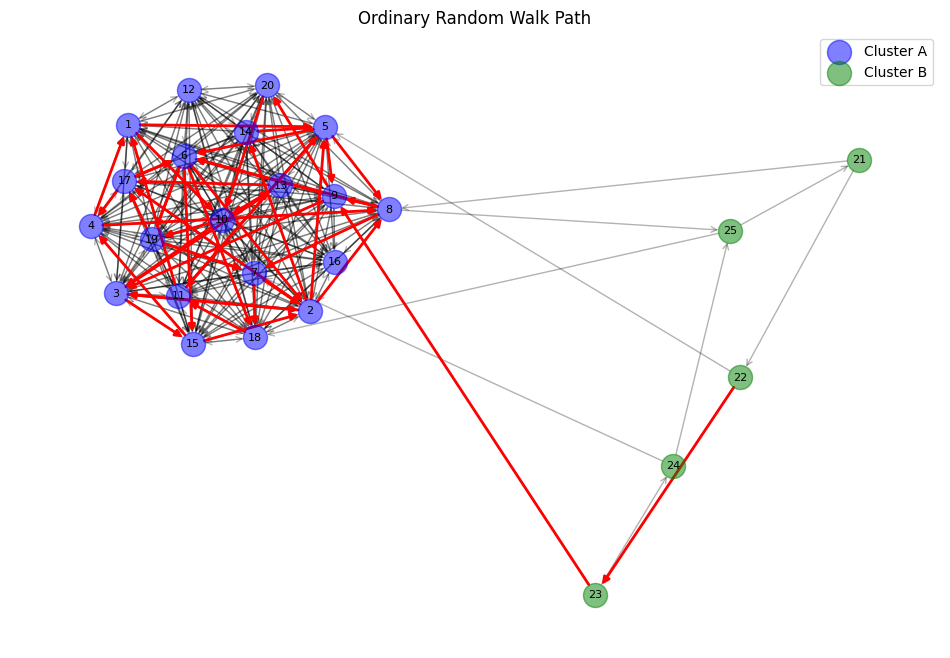

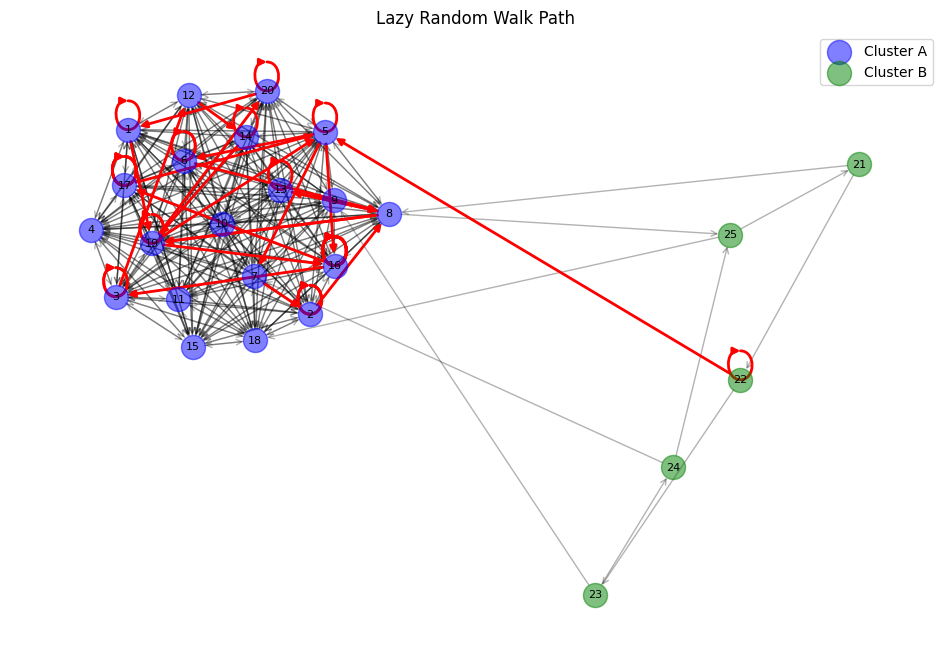

In [10]:
def simulate_random_walk(G, start_node, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

def simulate_random_walk_lazy(G, start_node, lazy_prob=0.5, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        if random.random() < lazy_prob:
            path.append(current_node)  # Stay at the same node
            continue
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

# Select a start node from Cluster B
start_node = random.choice(list(cluster_b_nodes))
print(f"Simulating walks starting from Node {start_node} (Cluster B)")

# Simulate Ordinary Random Walk
path_ord = simulate_random_walk(G, start_node)

# Simulate Lazy Random Walk
path_lazy = simulate_random_walk_lazy(G, start_node, lazy_prob=0.5)

# Function to highlight paths on the graph
def plot_walk_path(G, path, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', alpha=0.5, label='Cluster A')
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', alpha=0.5, label='Cluster B')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.3)
    # Highlight the path
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

# Plotting the paths
plot_walk_path(G, path_ord, 'Ordinary Random Walk Path')
plot_walk_path(G, path_lazy, 'Lazy Random Walk Path')


Why Did Ordinary PageRank Converge Faster in Graph 1?

- **Graph Structure**: The graph had strong connectivity within Cluster A and sparse connectivity in Cluster B, with bidirectional bridging edges.

- **Impact on Random Walks**: In such a graph, the ordinary random walk moves quickly due to high connectivity, especially within Cluster A.

- **Lazy Random Walk Effect**: Introducing laziness (probability of staying at the same node) can slow down the convergence in graphs that are already well-connected because it reduces the movement across nodes.

Why Did Lazy PageRank Converge Faster in Graph 2?

- **Dangling Nodes (9, 10, 11, 12, 13, 14):** Lazy PageRank mitigates the need to redistribute ranks uniformly across the graph, reducing global computation.

- **Disconnected Components ({1, 2, 3, 4} and {5, 6, 7, 8}):** Lazy PageRank keeps rank localized longer within components, accelerating local convergence.

- **Strong Local Clusters:** Nodes within clusters (e.g., {1, 2, 3, 4}) strongly reinforce ranks among themselves, stabilizing faster in Lazy PageRank due to reduced inter-cluster rank dispersion.

- **Reduced Teleportation Effect:** Lazy PageRank limits excessive jumping to unrelated nodes, allowing ranks to stabilize more efficiently in dense substructures.

In a simple random walk on a graph, the transition probability from node $ i $ to node $ j $ is given by the transition matrix $ P $, where $ P_{ij} = \frac{1}{\text{deg}(i)} $ if there is an edge between $ i $ and $ j $, and 0 otherwise. This means that at each time step $ t $, the probability distribution $ \pi_t $ evolves according to:

$
\pi_{t+1} = \pi_t P.
$

In a lazy random walk, the walker has a probability $ \alpha $ of staying at the current node and a probability $ (1 - \alpha) $ of moving to a neighboring node. The transition matrix $ P_{\text{lazy}} $ for the lazy random walk is therefore:

$
P_{\text{lazy}} = \alpha I + (1 - \alpha) P,
$

where $ I $ is the identity matrix. This modification introduces self-loops at each node with probability $ \alpha $.

At time $ t+1 $, the probability distribution $ \pi_{t+1} $ in the lazy random walk evolves as:

$
\pi_{t+1} = \pi_t P_{\text{lazy}} = \alpha \pi_t I + (1 - \alpha) \pi_t P = \alpha \pi_t + (1 - \alpha) \pi_t P.
$

**Observation:** The key difference between the lazy random walk and the simple random walk is the inclusion of the term $ \alpha \pi_t $, representing the probability of the walker staying at the current node. This self-loop slows down the convergence of the walk compared to the simple random walk because the probability distribution changes more gradually over time.

---


Given the PageRank transition matrix:

$
P_g = (1 - p) P + p B,
$

where $ P $ is a stochastic matrix, $ B = \frac{1}{n} \mathbf{1}_{n \times n} $ is a matrix where each entry is $ \frac{1}{n} $, and $ p $ is the damping factor (typically $ p = 0.15 $).

To prove that $ P_g $ remains stochastic, we need to show two things:

1. **Non-negativity:** All entries of $ P_g $ are non-negative.
2. **Row sums equal to 1:** The sum of each row in $ P_g $ is 1.

**Proof:**

1. **Non-negativity:**
   - Since $ P $ is stochastic, $ P_{ij} \geq 0 $ for all $ i, j $.
   - Since $ B_{ij} = \frac{1}{n} \geq 0 $ for all $ i, j $.
   - The coefficients $ (1 - p) $ and $ p $ are non-negative (since $ p \in [0,1] $).
   - Therefore, $ P_g $ entries are non-negative:
     $
     P_g[i][j] = (1 - p) P[i][j] + p B[i][j] \geq 0.
     $

2. **Row sums equal to 1:**
   - For each row $ i $:
     $
     \sum_{j} P_g[i][j] = (1 - p) \sum_{j} P[i][j] + p \sum_{j} B[i][j].
     $
   - Since $ P $ is stochastic:
     $
     \sum_{j} P[i][j] = 1.
     $
   - Since $ B[i][j] = \frac{1}{n} $:
     $
     \sum_{j} B[i][j] = n \times \frac{1}{n} = 1.
     $
   - Therefore:
     $
     \sum_{j} P_g[i][j] = (1 - p)(1) + p(1) = 1.
     $

**Conclusion:** Since $ P_g $ has non-negative entries and each row sums to 1, $ P_g $ remains a stochastic matrix.